# Maccabi Home Task - DS Position (PART II)

Name: Eitan Boker

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = [7, 5]
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('ds_assignment_data_maccabi.csv')

In [3]:
df.shape

(10000, 157)

## 1. Train-Test Split

I will begin by performing an immediate train-test split.

This is a crucial first step in the pipeline to prevent **data leakage** between the subsets.

In [4]:
from sklearn.model_selection import train_test_split

class TrainTestSplit:
    """
    A class to handle train-test splitting of a dataset.
    """
    def __init__(self, test_size, stratify, random_state):
        """
        Parameters:
        - test_size (float): Proportion of the dataset to include in the test split.
        - stratify (bool): Stratify the split based on the target variable.
        - random_state (int): Random seed.
        """
        self.test_size = test_size
        self.stratify = stratify
        self.random_state = random_state

    def split(self, X, y):
        """
        Parameters:
        - X (DataFrame): Dependent features
        - y (Series): Inependent feature

        Returns:
        - X_train, X_test, y_train, y_test: Split datasets
        """
        if self.stratify:
            return train_test_split(
                X, y,
                test_size = self.test_size,
                stratify = y, #stratify = True
                random_state = self.random_state
            )
        else:
            return train_test_split(
                X, y,
                test_size = self.test_size,
                random_state = self.random_state
            )

In [5]:
target_feature = 'Y'

X = df.drop(columns = [target_feature])
y = df[target_feature]

splitter = TrainTestSplit(test_size = 0.25, stratify = True, random_state = 42)
X_train, X_test, y_train, y_test = splitter.split(X,y)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7500, 156) (7500,) (2500, 156) (2500,)


## 2. Data Cleansing

In this section, I will clean the dataset and prepare it for training.

Due to the sensitive nature of the data (medical records), I will avoid imputing missing values.

As noted during the EDA, the presence of null values are expected, and therefore will be preserved 'as-is'.

In [6]:
class DataCleansing:
    """
    A class to handle data cleaning operations tailored for sensitive medical data.
    """

    def __init__(self, smoking_max_years = 60):
        self.smoking_max_years = smoking_max_years

        # Features to remove due to high null rate and no impact on Y
        self.features_to_remove = [
            '4_diag_136_days_since_last_diag',
            '24_diag_77_days_since_last_diag',
            '4_diag_102_days_since_last_diag',
            '4_diag_120_days_since_last_diag',
            '24_diag_73_days_since_last_diag',
            '4_diag_106_days_since_last_diag',
            '4_diag_126_days_since_last_diag',
            '4_diag_90_days_since_last_diag',
            '4_diag_88_days_since_last_diag',
            'int_date'
        ]

    def clean_smoking_years(self, df, column = 'smoking_smoking_years'):
        """
        Converts unrealistic values in the smoking_smoking_years column to NaN.
        """
        count_invalid = 0
        for i in df.index:
            value = df.at[i, column]
            if pd.notna(value) and value > self.smoking_max_years:
                df.at[i, column] = np.nan
                count_invalid += 1

        print(f"Converted {count_invalid} values > {self.smoking_max_years} in '{column}' to NaN.")
        return df

    def remove_useless_columns(self, df):
        """
        Removes predefined columns that are mostly null and have no predictive value.
        """
        removed_cols = [col for col in self.features_to_remove if col in df.columns]
        df = df.drop(columns = removed_cols)
        return df


In [7]:
cleanser = DataCleansing(smoking_max_years = 60)

X_train = cleanser.clean_smoking_years(X_train)
X_train = cleanser.remove_useless_columns(X_train)

X_test = cleanser.clean_smoking_years(X_test)
X_test = cleanser.remove_useless_columns(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Converted 109 values > 60 in 'smoking_smoking_years' to NaN.
Converted 31 values > 60 in 'smoking_smoking_years' to NaN.
(7500, 146) (7500,) (2500, 146) (2500,)


## 3. Feature Engineering

This section is dedicated to extracting and engineering new features from the existing data

In [8]:
import re

class FeatureEngineering:
    """
    A class to engineer features from diagnosis-related columns.
    This includes summarizing sparse diagnosis timing columns and diagnosis count columns.
    """

    def __init__(self, diag_features = None, diag_count_features = None):
        """
        Initializes the feature engineering class.
        """
        self.diag_features = diag_features 
        self.diag_count_features = diag_count_features

        # Define keyword dictionaries
        self.warning_keywords = [
            "החמרה", "כאבים", "כאב", "כאב ראש", "כאבי גב",
            "לחץ דם גבוה", "חלבון בשתן", "אנמיה", "המוגלובין נמוך",
            "מעקב צמוד", "מומלץ מעקב", "בדיקה חוזרת",
            "PAPP-A נמוך", "CRP גבוה", "השמנה", "BMI גבוה", "סיכון יתר",
            "תסמונת מטבולית", "רעלת", "היסטוריה משפחתית של לחץ דם"
        ]

        self.safe_keywords = [
            "ללא תלונות", "מצב תקין", "בדיקה תקינה", "בדיקות תקינות",
            "שיפור", "הקלה", "מרגישה טוב", "לחץ דם תקין",
            "דופק תקין", "הרחם תואם לשבוע", "סקירה תקינה", "אין בצקות", "אין דימומים"
        ]

    def summarize_diag_features(self, df):
        """
         Generates summary features based on diagnosis timing columns:
         - 'diag_non_missing_count': counts the number of non-null diagnosis timing fields per row.
         - 'diag_non_missing_sum': sums the values of available diagnosis timing fields per row.
        """
        df['diag_non_missing_count'] = df[self.diag_features].notnull().sum(axis = 1)
        df['diag_non_missing_sum'] = df[self.diag_features].sum(axis=1, skipna = True)
        return df

    def summarize_diag_counts(self, df):
        """
       Creates two aggregated features from diagnosis count columns:
        - 'total_diag_sum': the total number of diagnosis occurrences across all types.
        - 'active_diag_types': the number of distinct diagnosis types with at least one recorded occurrence.
        """
        df['total_diag_sum'] = df[self.diag_count_features].sum(axis = 1)
        df['active_diag_types'] = (df[self.diag_count_features] > 0).sum(axis = 1)
        
        df = df.drop(columns=self.diag_count_features)
        return df

    def remove_leakage_features(self, df):
        """
        Removes features that could leak label information, excluding engineered aggregates.
        """
        # Avoid removing features that are engineered
        safe_sums = ['diag_non_missing_sum', 'total_diag_sum', 'diag_non_missing_sum', 'active_diag_types']
        
        leakage_cols = [
            col for col in df.columns
            if (col.endswith('_sum') and col not in safe_sums)
            or (col.startswith('match_') and col.endswith('_after'))
            or (col.startswith('match_') and col.endswith('_141'))
        ]
        df = df.drop(columns = leakage_cols)
        df = df.drop(columns = self.diag_features)
        
        return df

    def extract_text_sentiment(self, df, text_column = 'clinical_sheet'):
        """
        Creates a sentiment score from clinical text notes based on keyword matching.

        +1 for each 'safe' keyword
        -1 for each 'warning' keyword
        """
        def score_text(text):
            score = 0
            for w in self.safe_keywords:
                if w in text:
                    score -= 1
            for w in self.warning_keywords:
                if w in text:
                    score += 1
            return score

        df['clinical_sentiment_score'] = df[text_column].fillna("").apply(score_text)
        return df

    def add_regex_flags(self, df, text_column):
        """
        Adds binary features based on keyword/phrase matches using regex from clinical notes.
        Uses stricter word-boundary matching to reduce false positives.
        """
        patterns = {
            "high_blood_pressure": r"\b(?:לחץ\s+)?דם\s+גבוה\b",
            "is_smoker_text": r"\b(?:מעשנת|עישון|מעשנת\s+כבדה|מעשנת\s+לשעבר)\b"
        }
    
        for col_name, pattern in patterns.items():
            df[col_name] = df[text_column].astype(str).apply(lambda x: 1 if re.search(pattern, x) else 0)

        df = df.drop(columns=['clinical_sheet'])
        return df

In [9]:
diag_features = [col for col in X_train.columns if 'days_since_last_diag' in col]
diag_count_features = [col for col in X_train.columns if col.endswith('num_of_diag')]

fe = FeatureEngineering(diag_features = diag_features, diag_count_features = diag_count_features)

X_train = fe.summarize_diag_features(X_train)
X_test = fe.summarize_diag_features(X_test)

X_train = fe.summarize_diag_counts(X_train)
X_test = fe.summarize_diag_counts(X_test)

X_train = fe.remove_leakage_features(X_train)
X_test = fe.remove_leakage_features(X_test)

X_train = fe.extract_text_sentiment(X_train)
X_test = fe.extract_text_sentiment(X_test)

X_train = fe.add_regex_flags(X_train, text_column = 'clinical_sheet')
X_test = fe.add_regex_flags(X_test, text_column = 'clinical_sheet')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7500, 59) (7500,) (2500, 59) (2500,)


## 4. Feature Selection

Feature selection is used to reduce the dimensionality of the dataset.

The selection process is performed only on the training set to avoid data leakage.

Based on the selected features, the same subset will then be applied to the test set.

In [10]:
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb

class FeatureSelection:
    """
    Feature selection class to:
    1. Remove low variance features
    2. Remove highly correlated features
    3. Compute feature importance using XGBoost
    """

    def __init__(self):
        self.variance_selector = None
        self.removed_corr_features = {}
        self.importance_series = None

    def variance_threshold(self, X):
        """
        Removes features with low variance.
        """
        self.variance_selector = VarianceThreshold(threshold = 0.05)
        self.variance_selector.fit(X)
        
        support_mask = self.variance_selector.get_support()
        kept_features = X.columns[support_mask]
        removed_features = X.columns[~support_mask]

        print(f"Removed {len(removed_features)} low-variance features:")
        print(list(removed_features))

        return X[kept_features]

    def remove_high_corr_features(self, X, feature_groups, threshold = 0.80):
        """
        Removes highly correlated features from given feature groups.
        """
        for group_name, feature_list in feature_groups.items():
            subset = [f for f in feature_list if f in X.columns]
            corr_matrix = X[subset].corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

            to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
            X = X.drop(columns=to_drop)
            self.removed_corr_features[group_name] = to_drop

        return X

    def compute_feature_importance(self, X, y, max_depth = 3, n_estimators = 100):
        """
        Computes and plots XGBoost-based feature importances.
        """
        model = xgb.XGBClassifier(
            use_label_encoder =  False,
            eval_metric = "logloss",
            n_estimators = n_estimators,
            max_depth = max_depth,
            tree_method = "hist",
            enable_categorical = False
        )

        model.fit(X, y)
        importance = model.feature_importances_
        self.importance_series = pd.Series(importance, index = X.columns).sort_values(ascending = False)

        print("Top 20 most important features:")
        print(self.importance_series.head(20))

        # Plot
        self.importance_series.head(20).plot(kind = 'barh', title = 'Top 20 Feature Importances (XGBoost)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        return self.importance_series


In [11]:
fs = FeatureSelection()

# Remove features with low variance
X_train = fs.variance_threshold(X_train)

# Remove features that are highly correlated
lab_features = [col for col in X_train.columns if col.startswith('lab_')]
measure_features = [col for col in X_train.columns if col.startswith('measure_')]
smoking_features = smoking_features = [col for col in X_train.columns if 'smok' in col]

feature_groups = {
    "lab": lab_features,
    "measure": measure_features,
    "smoking": smoking_features
}

X_train = fs.remove_high_corr_features(X_train, feature_groups)

# Apply same selection to test set
X_test = X_test[X_train.columns]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Removed 5 low-variance features:
['demog_capitationcoefficient', 'lab_num_of_fetuses_last_value', 'lab_Eosinophils_1_last_value', 'lab_Monocytes_2_last_value', 'high_blood_pressure']
(7500, 39) (7500,) (2500, 39) (2500,)


Top 20 most important features:
measure_blood_pressure_dias_max_val                     0.082617
clinical_sentiment_score                                0.059854
measure_blood_pressure_sys_max_val                      0.041700
is_smoker_text                                          0.040706
measure_blood_pressure_dias_min_val                     0.040603
lab_weight_at_lab_time_last_value                       0.039957
measure_blood_pressure_sys_min_val                      0.038061
measure_blood_pressure_dias_first_last_percent          0.037237
total_diag_sum                                          0.031070
demog_customer_age                                      0.029270
lab_Platelets (PLT)_last_value                          0.028840
smoking_smoking_years                                   0.027525
smoking_is_smoker                                       0.026045
lab_Lymphocytes_2_last_value                            0.026006
measure_blood_pressure_sys_first_last_percent           0.

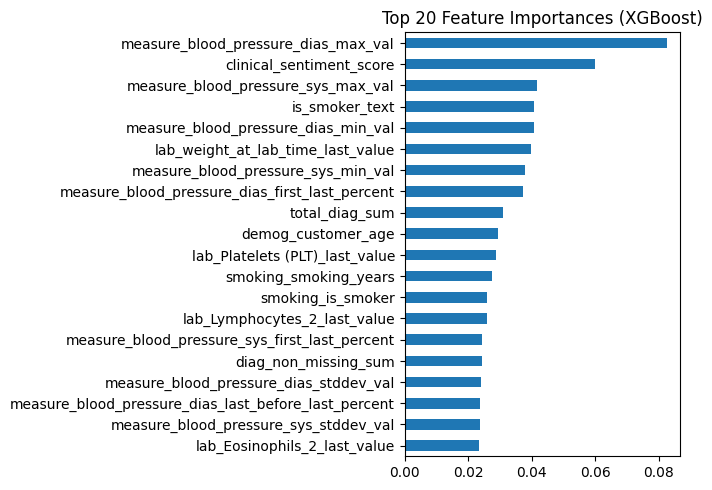

In [13]:
importance = fs.compute_feature_importance(X_train, y_train)

In [14]:
#get top 20 feature names
top_20_features = fs.importance_series.head(20).index.tolist()

X_train = X_train[top_20_features]
X_test = X_test[top_20_features]

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7500, 20) (7500,) (2500, 20) (2500,)


## 5. Model Training

In [16]:
from xgboost import XGBClassifier

class ModelTrainer:
    """
    Class to handle training of an XGBoost classifier, accounting for class imbalance.
    """

    def __init__(self, random_state = 12):
        self.random_state = random_state
        self.model = None

    def compute_scale_pos_weight(self, y):
        """
        Computes the scale_pos_weight parameter for imbalanced binary classification.
        """
        n_negative = (y == 0).sum()
        n_positive = (y == 1).sum()
        return n_negative / n_positive

    def train(self, X_train, y_train):
        """
        Trains the XGBoost classifier using the training data.
        """
        scale_pos_weight = self.compute_scale_pos_weight(y_train)

        self.model = XGBClassifier(
            n_estimators = 100,
            learning_rate = 0.1,
            max_depth = 5,
            scale_pos_weight = scale_pos_weight,
            use_label_encoder = False,
            eval_metric = 'logloss',
            random_state = self.random_state
        )
        self.model.fit(X_train, y_train)
        return self.model

In [17]:
trainer = ModelTrainer()

model = trainer.train(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

## 6. Model Evaluation

In [18]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
class Evaluator:
    def __init__(self):
        pass

    def top_percentile_eval(self, y_true, y_proba, percentile = 95):
        """
        Evaluate performance on the top X% of predicted risk scores.
        """
        cutoff = np.percentile(y_proba, percentile)
        top_mask = y_proba >= cutoff
        y_true_top = y_true[top_mask]
        y_pred_top = (y_proba[top_mask] >= cutoff).astype(int)
        y_proba_top = y_proba[top_mask]

        print(f"{percentile}% Percentile (Only {top_mask.sum()} samples)")
        self._print_metrics(y_true_top, y_pred_top, y_proba_top)
        self._plot_roc_curve(y_true_top, y_proba_top)

    def _print_metrics(self, y_true, y_pred, y_proba):
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:   ", recall_score(y_true, y_pred))
        print("F1 Score: ", f1_score(y_true, y_pred))
        print("AUC:      ", roc_auc_score(y_true, y_proba))
        print("-" * 30)

    def _plot_roc_curve(self, y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-AUC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

99% Percentile (Only 25 samples)
Precision: 0.28
Recall:    1.0
F1 Score:  0.4375
AUC:       0.7063492063492063
------------------------------


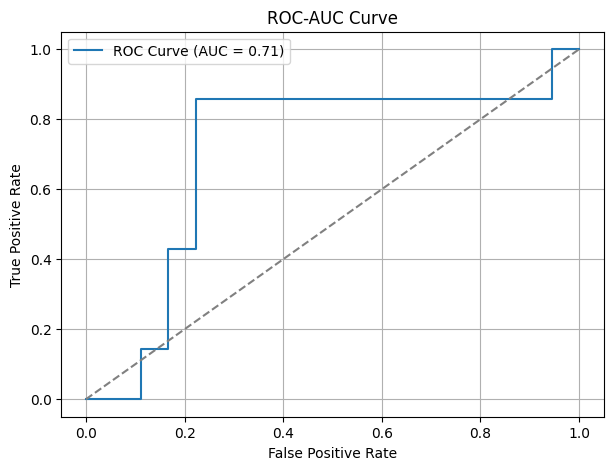

In [19]:
evaluator = Evaluator()

# Top 1% risk group (99% Percentile)
evaluator.top_percentile_eval(y_test, y_proba, percentile = 99)